#Notes

* DDPG combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network). It uses Experience Replay and slow-learning target networks from DQN, and it is based on DPG, which can operate over continuous action spaces.

* Just like the Actor-Critic method, we have two networks: 
 * Actor - It proposes an action given a state. 
 * Critic - It predicts if the action is good (positive value) or bad (negative value) given a state and an action.


In [ ]:
import cv2
import os
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime as dt
import tensorflow as tf

from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.preprocessing import normalize


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Params

In [ ]:
#Environment params
TIMESTEP = 15
FEATSNUM = 6
TRAIN_TEST = "2019-05-03"
#eur xau sp nasdaq usd
INSTRUMENTNUM = 5
INSTRUMENTS = ("EURUSD=X", "GC=F", "^GSPC", "^IXIC", "USD")


EPISODES = 5

#model
ACTIVATION_ACTOR = "relu"
ACTIVATION_CRITIC = "relu"

# Utils

In [ ]:
def normalize(v):
    norm = tf.math.reduce_sum(v)
    if(norm == 0):
        print(v)
        print(norm)
        result = np.array([[0, 0, 0, 0, 1]])
    else:
        result = v / norm

    return result

In [ ]:
class EpisodeData:

    def __init__(self):
        self.rewards = list()
        self.totalOfGoods = list()

    def add(self, reward, totalOfGood):
        self.rewards.append(reward)
        self.totalOfGoods.append(totalOfGood)

    def plot(self):
        plt.plot(self.totalOfGoods)
        plt.show()

# For Noise

In [ ]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

# Environment Class



*   Alım yaparken bir önceki is gününün kapanış fiyatına göre yapıyor



In [ ]:
class Market:
    def __init__(self, totalOfGoods : float = 1000., howToReorganize : bool = False ,startDateOfMarket : dt.datetime =  dt.datetime(2004,1,1), endDateOfMarket : dt.datetime =  dt.datetime(2018,1,1)):
        #hold copy of totalOfGoods for reseting environment
        self._startGoodsValue = totalOfGoods
        self.bigData = list()
        self._initializationOfVariables()
        self._lastDate = 0
        self.howToReorganize = howToReorganize

        self.startDateOfMarket = startDateOfMarket
        self.endDateOfMarket = endDateOfMarket
        

    def _retrieveData(self) -> None:
        """
        Retrieve instuments data from market

        Returns None
        """
        for instrument in INSTRUMENTS:
            if (instrument == "USD"):
                continue
            df = web.DataReader(instrument, "yahoo", self.startDateOfMarket, self.endDateOfMarket)
            self.bigData.append(df)

        if (self.howToReorganize):
            self.reorganizeBigDataGetAll()
        else:
            self.reorganizeBigData()
    
    def reorganizeBigData(self):
        """
        burada hepsini euro dolara göre aldım
        """

        self.bigData[0] = self.bigData[0].shift(1, freq = "D")
        usaIndex = set(self.bigData[0].index)
        goldIndex = set(self.bigData[1].index)
        londonIndex = set(self.bigData[1].index)

        reIndex = usaIndex.union(goldIndex)
        self.bigData[1] = self.bigData[1].reindex(list(reIndex)).sort_index().ffill().bfill().reindex(self.bigData[0].index).sort_index().ffill().bfill()

        reIndex = usaIndex.union(londonIndex)
        self.bigData[2] = self.bigData[2].reindex(list(reIndex)).sort_index().ffill().bfill().reindex(self.bigData[0].index).sort_index().ffill().bfill()

        self.bigData[3] = self.bigData[3].reindex(list(reIndex)).sort_index().ffill().bfill().reindex(self.bigData[0].index).sort_index().ffill().bfill()

    def reorganizeBigDataGetAll(self):
        """
        nu metodla hepsinin günlerini esitledim
        """
        
        reIndex = set ()
        for df in self.bigData:
            temp = set (df.index)
            reIndex = reIndex.union(temp)
        
        for i in range(len(self.bigData)):
            self.bigData[i] = self.bigData[i].reindex(reIndex).ffill()
            self.bigData[i].bfill(inplace = True)
            self.bigData[i].sort_index(inplace=True)

    def _initializationOfVariables(self) -> None:
        """
        Every time user call reset method _initializationOfVariables method invoked automatically to reset necessary variables
        to their initial values

        Returns None
        """
        
        self.totalOfGoods = self._startGoodsValue
        self.analizeStartDate = 0 
        self.timeInterval = TIMESTEP
        self.currentDate = TIMESTEP

        # basket is a list that holds how much of instruments is in our basket by its unit 
        self.basket = np.zeros(INSTRUMENTNUM)
        self.weights = np.zeros(INSTRUMENTNUM)

        self.weights[INSTRUMENTNUM-1] = 1
        self.basket[INSTRUMENTNUM-1] = self.totalOfGoods
        
    
    def start(self) -> np.array:
        """
        Start environment by retreiving necessary market data.

        Returns state
        """
        self._retrieveData()
        #set last date
        self._lastDate = len(self.bigData[0])
        
        state = self._getCurrentState()
        return state


    def reset(self):
        self._initializationOfVariables()
        state =  self._getCurrentState()
        return state



    def _getCurrentState(self) -> np.array:
        """
        Calculate current state respective to self.currentDate

        Returns current State of market as a np.array
        """
        state = list ()
        for instrumentDF in self.bigData:
            df = instrumentDF.iloc[self.analizeStartDate:self.currentDate,:].copy()
            
            #normalize data and rearrange headers
            self.preprocessRawData(df)
            state.append(df)
        
        #its Shape is (INSTRUMENTNUM - 1,TIMESTEP,FEATSNUM,1) 
        return np.array(state).reshape((-1,TIMESTEP,FEATSNUM,1))

    def preprocessRawData(self, df) -> None:
        # High       Low      Open     Close  Volume  Adj Close
        df["H"] = df.loc[:, "High"] / df.iloc[0, 0]
        df["L"] = df.loc[:, "Low"] / df.iloc[0, 1]
        df["H-Step"] = (df.loc[:, "High"] - df.loc[:, "Low"]) / df.loc[:, "Low"]
        #df["C"] = df.loc[:, "Close"] / df.iloc[0, "Close"] 
        df["O"] = df.loc[:, "Open"] / df.iloc[0, 2]
        df["C-Step"] = (df.loc[:, "Close"] - df.loc[:, "Open"] ) / df.loc[:, "Open"]
        df.loc[:, "Adj Close"] = df.loc[:, "Adj Close"] / df.iloc[0, 5]
        df.drop(["Volume", "High", "Close", "Low", "Open"],axis=1 , inplace= True)


    def _buyAllInstruments(self, logFile):
        
        loss : float = 0

        closePrices = list ()

        for index in range(INSTRUMENTNUM-1):
            closePrice = self.bigData[index].iloc[self.currentDate-1 , 3]
            
            
            closePrices.append(closePrice)
            
            
            unitLoss = self.totalOfGoods * self.weights[index]
            loss += unitLoss
            self.basket[index] =  unitLoss / closePrice if ( unitLoss != 0 ) else 0
        
        #for dolar
        index += 1
        self.basket[index] = self.totalOfGoods * self.weights[index]

        logFile.write(f"buy prices: {closePrices}\n")
        logFile.write(f"basket after buy: {self.basket}\n")

        return loss

    def _sellAllInstruments(self, logFile) -> float:
        """
        this method sells all instruments and adds profit to "totalOfGoods"
        """
        profit = 0


        closePrices = list ()

        #because last one is usd
        for index in range(INSTRUMENTNUM-1):
            closePrice = self.bigData[index].iloc[self.currentDate, 3]


            closePrices.append(closePrice)


            unitProfit = closePrice * self.basket[index]
            profit += unitProfit
            self.basket[index] = 0. 
        

        logFile.write(f"sell prices: {closePrices}\n")
        

        index += 1
        self.totalOfGoods = profit + self.basket[index] if (profit + self.basket[index] != 0) else self.totalOfGoods
        return profit

    
    def incrementDay(self):
        """
        This method increment currentDate and _startDate and returns a bool value
        if new currentDate value is either more than or equal to _last day in our data then it returns False
        else it returns True
        """
        self.currentDate += 1
        self.analizeStartDate =  int(self.currentDate - self.timeInterval)

        done = self.currentDate >= self._lastDate - 1
        return done


    def step(self, weights : np.array, logFile, normalizedReward : float = False):
        """
        Buy instruments at last days close
        sell them all at close
        increment day

        weights: is an np.array that holds how to disturbue total money to insturuments which is also action
        normalizedReward: if it is true than returns normalized profit else normal profit default False 

        Returns (nextState, reward, done)
        """
        sumOfWeights = tf.math.reduce_sum(weights)
        #if(0.9< sumOfWeights <1.1):
        #    self.weights = np.array(weights).reshape((5,))
        #else:
        #    print(f"Weights has problems their sum is not one\nsum: {sumOfWeights}")
        #    print(f"State {self._getCurrentState()}")
        #    return False
        self.weights = np.array(weights)
        oldTotalOfGoods = self.totalOfGoods
        loss = self._buyAllInstruments(logFile)
        self.basketCopy = self.basket.copy()
        profit = self._sellAllInstruments(logFile)

        
        reward = (profit - loss) / oldTotalOfGoods if normalizedReward else profit - loss
        
        logFile.write(f"current day: {self.currentDate}\n")
        logFile.write(f"last day: {self._lastDate}\n")
        logFile.write(f"sum of weights: {sumOfWeights}\n")
        logFile.write(f"weights: {self.weights}\n")
        logFile.write(f"profit: {profit}\n")
        logFile.write(f"loss: {loss}\n")
        logFile.write(f"profit-loss: {profit - loss}\n")
        logFile.write(f"reward: {reward}\n")
        logFile.write(f"old totalOfGoods: {oldTotalOfGoods}\n")
        logFile.write(f"new totalOfGoods: {self.totalOfGoods}\n\n")
        done = self.incrementDay()

        nextState = self._getCurrentState()

        return (nextState, reward, done)


# DDPG kısmı komple degisecek

*   https://keras.io/api/models/model/
*   https://keras.io/examples/rl/ddpg_pendulum/
*   https://www.youtube.com/watch?v=4jh32CvwKYw


learning rate of critic network is sileltly higher than actor network and that is because in general in policy gradiend based methods the polict aproximation is a little bit more sensitive to the perturbation of and parameters

### GradientTape

*   https://medium.com/analytics-vidhya/tf-gradienttape-explained-for-keras-users-cc3f06276f22

If at any point, we want to use multiple variables in our calculations, all we need to do is give tape.gradient a list or tuple of those variables. When we optimize Keras models, we pass model.trainable_variables as our variable list.


This is because immediately after calling tape.gradient, the GradientTape releases all the information stored inside of it for computational purposes.
If we want to bypass this, we can set persistent=True


# Replay Memory

In [ ]:
class ReplayBuffer:
    def __init__(self, maxSize, inputShape, nActions):
        self.memberSize = maxSize
        self.memberCounter = 0
        self.stateMemory = np.zeros((self.memberSize, *inputShape))
        self.newStateMemory = np.zeros((self.memberSize, *inputShape))
        self.actionMemory = np.zeros((self.memberSize, nActions))
        self.rewardMemory = np.zeros((self.memberSize))
        #it indicates that self.memberCounter exceeds self.memberSize at least once
        self.sizeFlag = False

        #terminal state i hafızada tutmak istemiyorum

    def storeTransition(self, state : np.array, action : np.array, reward : float, newState : np.array) -> None:

        self.stateMemory[self.memberCounter] = state
        self.actionMemory[self.memberCounter] = action
        self.rewardMemory[self.memberCounter] = reward
        self.newStateMemory[self.memberCounter] = newState

        self.memberCounter += 1
        
        if(self.memberCounter == self.memberSize):
            self.sizeFlag = True 

        self.memberCounter = self.memberCounter % self.memberSize
        

    
    def sampleBuffer(self, batchSize : int) -> np.array:
        maxIndex = self.memberSize if self.sizeFlag else self.memberCounter

        batch = np.random.choice(maxIndex, batchSize, replace = False)

        states = self.stateMemory[batch]
        newStates = self.newStateMemory[batch]
        actions = self.actionMemory[batch]
        rewards = self.rewardMemory[batch]

        return states, actions, rewards, newStates

# ActorNetwork

In [ ]:
class ActorNetwork(keras.Model):
    def __init__(self, nActions = 5, modelName : str = "Actor", checkPointDirectory : str = "saves/ddpg"):
        super(ActorNetwork, self).__init__()

        self.modelName = modelName
        self.checkpointDir = checkPointDirectory 
        self.checkpointFile = os.path.join(self.checkpointDir, 
                    self.modelName+'_ddpg.h5')

        self.inputLayer = Dense(1024, dtype = "float32", activation = ACTIVATION_ACTOR)
        self.inputLayer_ = Dense(1024, dtype = "float32", activation = ACTIVATION_ACTOR)
        self.interLayer3 = Dense(1024, dtype = "float32", activation = ACTIVATION_ACTOR)
        self.interLayer4 = Dense(512, dtype = "float32", activation = ACTIVATION_ACTOR)
        self.mu = Dense(nActions, dtype = "float32", activation= "softmax")

    def call(self, state):
        #state = tf.convert_to_tensor([state], dtype = tf.float32)
        prob = self.inputLayer(state)
        prob = self.inputLayer_(prob)
        prob = self.interLayer3(prob)
        prob = self.interLayer4(prob)

        mu = self.mu(prob)
        #total of them must be 1
        #mu = normalize(mu)

        return mu

# ActorNetwork

In [ ]:
class CriticNetwork(keras.Model):
    def __init__(self, modelName : str = "critic", checkPointDirectory : str = "saves/ddpg") -> None:
        super(CriticNetwork, self).__init__()

        self.modelName = modelName
        self.checkpointDir = checkPointDirectory 
        self.checkpointFile = os.path.join(self.checkpointDir, 
                    self.modelName+'_ddpg.h5')

        self.inputLayer = Dense(512, activation = ACTIVATION_CRITIC, name = "input yeri")
        self.interLayer1 = Dense(1024, activation = ACTIVATION_CRITIC)
        self.interLayer2 = Dense(1024, activation = ACTIVATION_CRITIC)
        self.interLayer3 = Dense(512, activation = ACTIVATION_CRITIC)
        self.q = Dense(1, name="cikti")

    
    def call(self, state, action):
        actionValue = self.inputLayer(tf.concat([state, action], axis=1))
        actionValue = self.interLayer1(actionValue)
        actionValue = self.interLayer2(actionValue)
        actionValue = self.interLayer3(actionValue)

        qValue = self.q(actionValue)

        return qValue

# DDPG Agent Class

In [ ]:
class Agent:
    def __init__(self, inputDims, alpha = 0.01, beta = 0.02, actionMax = 1., \
        actionMin : float = 0, gamma = 0.99, nActions = 5, maxSize = 100000, tau = 0.005,\
        batchSize = 64, noise = 0.1):
        """
        alpha is learning rate for actor network
        beta is learning rate for critic network
        actionMax is max limit of action that agent can take 
        actionMin is min limit of action that agent can take 
        gama is discount foctor for update equation
        maxSize is limit for replay buffer
        tau is soft update factor
        noise is stddev valu of noise that is going to use for exploration

        beta is slightly higher than alpa and that is because in general in policy gradient type methods the policy approximation is a little bit more sensitive to
        pertubation and parameters.

        actionMax and actionMin are going to use for clipping after noise added to action for exploration
        
        default value of tau came from paper
        """

        self.gamma = gamma 
        self.tau = tau
        self._memory = ReplayBuffer(maxSize, inputDims, nActions)
        self.batchSize = batchSize
        self.nActions = nActions
        self.noise = noise
        self.maxAction = actionMax
        self.minAction = actionMin

        self.actor = ActorNetwork(nActions=nActions)
        self.critic = CriticNetwork()

        self.targetActor = ActorNetwork(nActions=nActions)
        self.targetCritic = CriticNetwork()

        self.actor.compile(optimizer= Adam(alpha))
        self.critic.compile(optimizer=Adam(beta))

        self.targetActor.compile(optimizer= Adam(alpha))
        self.targetCritic.compile(optimizer=Adam(beta))
        
        #tau is 1 because ve want hard copy
        self.updateNetworkParameters(tau = 1)


    def updateNetworkParameters(self, tau =None):
        
        tau = self.tau if tau is None else tau

        #soft update to target actor network
        networkWeights = []
        targetWeights = self.targetActor.weights
        for i, layerWeights in enumerate(self.actor.weights):
            networkWeights.append(layerWeights * tau + targetWeights[i] * (1 - tau))
        self.targetActor.set_weights(networkWeights)

        #soft update to target critic network
        networkWeights = []
        targetWeights = self.targetCritic.weights
        for i, layerWeights in enumerate(self.critic.weights):
            networkWeights.append(layerWeights * tau + targetWeights[i] * (1 - tau))
        self.targetCritic.set_weights(networkWeights) 


    def storeMemory(self, state, action , reward, newState):
        self._memory.storeTransition(state, action, reward, newState)

    def chooseAction(self, state, evaluate = False):
        state = tf.convert_to_tensor([state], dtype = tf.float32)
        actions = self.actor(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.nActions], \
                mean=0.0, stddev = self.noise, dtype = tf.float32)
            actions = tf.clip_by_value(actions, self.minAction, self.maxAction)
            actions = normalize(actions)
        
        return actions[0]

    def learn(self):
        if self._memory.memberCounter < self.batchSize:
            return
        states, actions, reward_, newStates = self._memory.sampleBuffer(self.batchSize)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        newStates = tf.convert_to_tensor(newStates, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward_, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)

        #q = reward + gamma * q_next
        #purpose of critic network is find q value of action for corresponding state
        #therefore, loss is difference of q values
        
        #with tf.GradientTape as tape:
        
        with tf.GradientTape() as tape:
            targetActions = self.targetActor(newStates)
            newCriticValue = tf.squeeze(self.targetCritic(newStates, targetActions), 1)

            criticValue = tf.squeeze(self.critic(states, actions), 1)
            
            target = reward + self.gamma * newCriticValue
            criticLoss = keras.losses.MSE(target, criticValue)
        #tape.__exit__()

        #find gradient
        criticNetworkGradient = tape.gradient(criticLoss, self.critic.non_trainable_variables)

        #optimize weights
        self.critic.optimizer.apply_gradients(zip(
            criticNetworkGradient, self.critic.trainable_variables
        ))

        #actor try to maximize q value 
        #Hence loss is -q

        with tf.GradientTape() as tape:
            newPolicyActions = self.actor(states)
            actorLoss = -self.critic(states, newPolicyActions)
            actorLoss = tf.math.reduce_mean(actorLoss)
        #tape.__exit__()

        actorNetworkGradient = tape.gradient(actorLoss,\
            self.actor.trainable_variables)
        
        self.actor.optimizer.apply_gradients(zip(
            actorNetworkGradient, self.actor.trainable_variables
        ))

        self.updateNetworkParameters()

In [ ]:
inputDims = TIMESTEP * FEATSNUM * (INSTRUMENTNUM - 1)
agent = Agent([inputDims], noise = 0.2, gamma=0.9, tau=0.05)
env = Market(startDateOfMarket=dt.datetime(2018,1,1), endDateOfMarket=dt.datetime(2018,4,1))
startState = env.start()


#for testing
testEnv = Market(startDateOfMarket=dt.datetime(2018,1,1), endDateOfMarket=dt.datetime(2018,4,1))
groundTruhth = Market(startDateOfMarket=dt.datetime(2018,1,1), endDateOfMarket=dt.datetime(2018,4,1))

testEnv.start()
groundTruhth.start()
print("")


# Test





In [ ]:
def test(agent : Agent):
    current_state = testEnv.reset().flatten()
    groundTruhth.reset()
    episodeLog = EpisodeData()
    episodeLogGT = EpisodeData()

    savePath = "/content/drive/MyDrive/DDPG/test/"
    done = False
    step = 0
    action = np.array([0] * 5)

    if(not os.path.exists(f"{savePath}")):
        os.mkdir(f"{savePath}")
        os.mkdir(f"{savePath}plots/")

    Log_file_name = f"testLog_{dt.datetime.now()}"
    Log_file_name_gt = f"{savePath}groundTruthLog_{dt.datetime.now()}.txt"
    logFile = open(savePath+Log_file_name+".txt", "w")
    groundTruthLogFile = open(f"{savePath}groundTruthLog_{dt.datetime.now()}.txt", "w")
    
    while (not done):
        logFile.write("-"*5 + f"Turn: {step} "+ "-"*5 + "\n")
        groundTruthLogFile.write("-"*5 + f"Turn: {step} "+ "-"*5 + "\n")

        _, reward_, _ =  groundTruhth.step(np.array([0.2] * 5), groundTruthLogFile, normalizedReward=False)

        episodeLogGT.add(reward_, groundTruhth.totalOfGoods)


        oldAction = action
        action = agent.chooseAction(current_state, evaluate = True)
        print("action: ",np.mean(action - oldAction))
        next_state, reward, done =  testEnv.step(action, logFile, normalizedReward=False)
        print("state: ", np.mean(current_state - next_state.flatten()))
        episodeLog.add(reward, testEnv.totalOfGoods)

        current_state = next_state.flatten()
        step += 1
    
    logFile.close()
    groundTruthLogFile.close()
    
    plt.plot(episodeLog.totalOfGoods, label="agent")
    plt.plot(episodeLogGT.totalOfGoods, label="GT")
    plt.legend()
    plt.savefig(savePath + "plots/" +Log_file_name + ".png")
    plt.clf()
    return episodeLog, episodeLogGT

In [ ]:
loadCheckPoint = False

episodeLogs = list ()

saveFile = "/content/drive/MyDrive/DDPG/train/"

for i in range(EPISODES):
    state = env.reset().flatten()
    done = False
    j = 0
    
    logFile = open(f"{saveFile}Episode_{i}.txt", "w")
    episodeLog = EpisodeData()
    episodeLogs.append(episodeLog)
    while not done:
        logFile.write("-"*5 + f" Episode: {i}, Turn: {j} "+ "-"*5 + "\n")
        action = agent.chooseAction(state, False)
        actionFloat64 = np.array(normalize(action)).astype(dtype="float64")
        stateNew, reward, done = env.step(action, logFile, normalizedReward=False)
        stateNew = stateNew.flatten()
        agent.storeMemory(state, action, reward, stateNew)
        episodeLog.add(reward, env.totalOfGoods)

        if not loadCheckPoint:
            agent.learn()
        state = stateNew
        j += 1
    agent.actor.save_weights(f"{saveFile}actor_{i}.h5", overwrite=True)
    agent.critic.save_weights(f"{saveFile}critic_{i}.h5", overwrite=True)
    logFile.close()
    test(agent)

action:  0.19999999
state:  0.002456759646384908
action:  1.4901161e-09
state:  0.001094414514188486
action:  5.9604646e-09
state:  -0.0002076058957797862
action:  -8.940697e-09
state:  -0.0013107690322087136
action:  2.9802323e-09
state:  -0.001340120847055578
action:  4.4703485e-09
state:  -0.0023473197142025496
action:  2.3841858e-08
state:  0.0006913633320925117
action:  -1.0430813e-08
state:  0.003018140809961992
action:  -7.450581e-09
state:  0.0008206505309369905
action:  -5.9604646e-09
state:  0.003051325342322472
action:  -8.940697e-09
state:  0.0015101726036576353
action:  2.3841858e-08
state:  0.0008928932458982505
action:  -5.9604646e-09
state:  0.001726101304245578
action:  -4.4703485e-09
state:  0.002070854221233108
action:  -1.3411045e-08
state:  0.0066056821916167085
action:  2.2351742e-08
state:  0.004153103372200217
action:  -4.4703485e-09
state:  0.0018413250989357422
action:  0.0
state:  0.0033698642764713755
action:  -1.4901161e-09
state:  0.000641422404619827
acti

<Figure size 432x288 with 0 Axes>

In [ ]:
len(episodeLogs)

5

In [ ]:
len(episodeLogs[0].rewards)

50

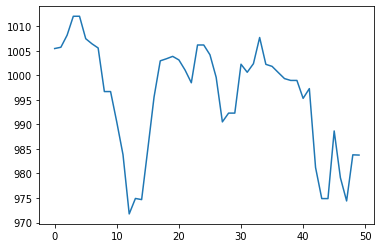

In [ ]:
episodeLogs[0].plot()